In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Clean background with gridlines for easy readability
plt.rcParams.update({
    "font.size": 12,          # Default font size for labels and titles
    "axes.labelsize": 14,     # Font size for axes labels
    "axes.titlesize": 16,     # Font size for title
    "xtick.labelsize": 12,    # Font size for x-tick labels
    "ytick.labelsize": 12,    # Font size for y-tick labels
    "legend.fontsize": 8,    # Decreased font size for legend text
    "figure.figsize": (8, 6), # Size of the figure (width, height in inches)
    "lines.linewidth": 2,     # Default line width for plot lines
    "lines.markersize": 8,    # Marker size for plot markers
    "grid.alpha": 0.3,        # Transparency for grid lines
    "axes.grid": True,        # Show grid lines
    "axes.edgecolor": 'black', # Edge color of axes
    "axes.linewidth": 1,      # Thickness of the axes lines
    "savefig.dpi": 300,       # Higher DPI for publication-quality output
    "savefig.transparent": True,  # Transparent background for saving
    "figure.autolayout": True  # Prevent overlapping labels and titles
})

import pickle
from paper_tree import PaperTree
import regex as re
import importlib

import torch
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import time
import chromadb
from sentence_transformers import SentenceTransformer

import rag
importlib.reload(rag)

<module 'rag' from '/n/home10/jmcgreivy/beauty-in-stats/tree_rag/rag.py'>

### Load the paper tree

In [21]:
load_dir = "./saved_paper_trees/summarized_openai_paper_trees/"
filenames = list(filter(lambda str : (".pkl" in str[-4:]), os.listdir(load_dir)))

papers = {}
for filename in filenames:
    if "2403.03710" not in filename:
        continue
    with open(load_dir + filename, "rb") as f:
        paper = pickle.load(f)
        papers[paper.title] = paper

## Evals for RAG performance

In [22]:
def generate_ngrams(text, n = 3):
    text = re.sub("\s+", " ", text)
    words = re.split(r"([.,;\{\}\(\)\s])", text)
    words = [word for word in words if len(word.strip()) > 0]
    ngrams = [" ".join(words[i:i + n]) for i in range(len(words) - n + 1)]
    return set(ngrams)

def overlap(str1, str2):
    str1 = generate_ngrams(str1)
    str2 = generate_ngrams(str2)
    return len(str1.intersection(str2)) / min(len(str1), len(str2))

def compute_overlap(answers, final_results):
    scores = [] 
    for label, chunk in final_results:
        for answer in answers:
            score = overlap(chunk, answer)
            if score < 0.25:
                score = 0
            scores.append(score)
    return sum(scores)

def evaluate_rag(rag, questions, n_results):
    queries = list(questions.keys())
    precisions, recalls, f1s = [], [], []
    for query in queries:
        answers = questions[query]
        results = rag.query(query, n_results = n_results)
        
        overlap = compute_overlap(answers, results)
        precision = overlap / len(results)
        recall = overlap / len(answers)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append( (2 * precision * recall) / (precision + recall + 1e-9) )
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

In [23]:
level_rerank_rag = rag.LevelSearchRerankRAG(papers)
level_rag = rag.LevelSearchRAG(papers)
base_rag = rag.BaseRAG(papers)
base_rerank_rag = rag.BaseRerankRAG(papers)

In [24]:
import json

filename = '2403.03710.json'
validation_data_dir = "./validation_data/jsons/"

with open(validation_data_dir + filename, 'r') as file:
    question_to_linenumbers = json.load(file)

split_tex_dir = "./validation_data/split_tex/"
with open(split_tex_dir + filename[:-5] + ".tex", 'r', encoding='utf-8') as file:
    lines = file.readlines()

In [25]:
question_to_answers = {}
for question in question_to_linenumbers:
    answers = []
    for start, end in question_to_linenumbers[question]:
        answer = re.sub("\s+", " ", "".join(lines[start - 1 : end]))
        answers.append(answer)
    question_to_answers[question] = answers

question_to_answers.pop('How is semileptonic background treated?')

[]

In [26]:
import time

n_results_range = np.arange(1, 11)

level_rerank_precision, level_rerank_recall, level_rerank_f1 = [], [], []
level_precision, level_recall, level_f1 = [], [], []
base_rerank_precision, base_rerank_recall, base_rerank_f1 = [], [], []
base_precision, base_recall, base_f1 = [], [], []
for n_results in n_results_range:
    n_results = int(n_results)
    print(n_results)
    precision, recall, f1 = evaluate_rag(level_rerank_rag, question_to_answers, n_results)
    level_rerank_precision.append(precision)
    level_rerank_recall.append(recall)
    level_rerank_f1.append(f1)
    
    precision, recall, f1 = evaluate_rag(level_rag, question_to_answers, n_results)
    level_precision.append(precision)
    level_recall.append(recall)
    level_f1.append(f1)
    
    precision, recall, f1 = evaluate_rag(base_rerank_rag, question_to_answers, n_results)
    base_rerank_precision.append(precision)
    base_rerank_recall.append(recall)
    base_rerank_f1.append(f1)
    
    precision, recall, f1 = evaluate_rag(base_rag, question_to_answers, n_results)
    base_precision.append(precision)
    base_recall.append(recall)
    base_f1.append(f1)

1


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


2
3
4
5
6
7
8
9
10


## Plot Precision, Recall, F1 Score

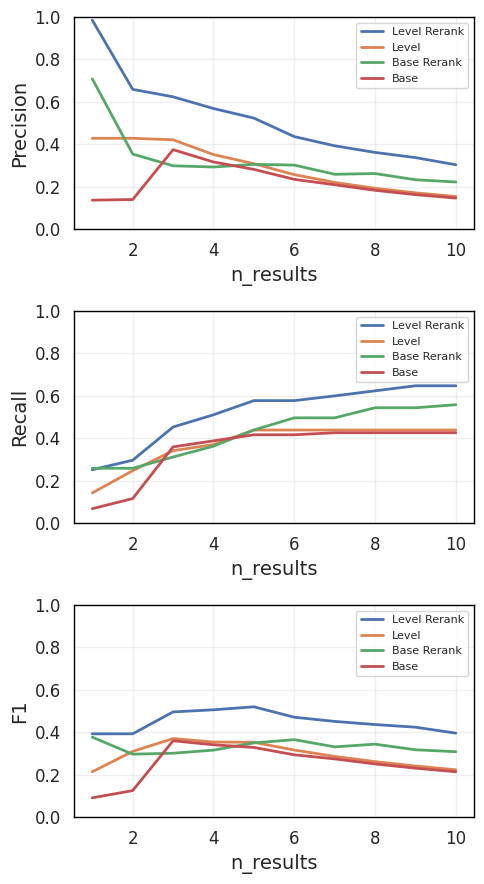

In [28]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 9))

axs[0].plot(n_results_range, level_rerank_precision, label="Level Rerank")
axs[0].plot(n_results_range, level_precision, label = "Level")
axs[0].plot(n_results_range, base_rerank_precision, label = "Base Rerank")
axs[0].plot(n_results_range, base_precision, label = "Base")
axs[0].legend()
axs[0].set_ylabel("Precision")
axs[0].set_xlabel("n_results")
axs[0].set_ylim(0, 1)


axs[1].plot(n_results_range, level_rerank_recall, label="Level Rerank")
axs[1].plot(n_results_range, level_recall, label = "Level")
axs[1].plot(n_results_range, base_rerank_recall, label = "Base Rerank")
axs[1].plot(n_results_range, base_recall, label = "Base")
axs[1].legend()
axs[1].set_ylabel("Recall")
axs[1].set_xlabel("n_results")
axs[1].set_ylim(0, 1)

axs[2].plot(n_results_range, level_rerank_f1, label="Level Rerank")
axs[2].plot(n_results_range, level_f1, label = "Level")
axs[2].plot(n_results_range, base_rerank_f1, label = "Base Rerank")
axs[2].plot(n_results_range, base_f1, label = "Base")
axs[2].legend()
axs[2].set_ylabel("F1")
axs[2].set_xlabel("n_results")
axs[2].set_ylim(0, 1)

plt.tight_layout()

plt.savefig("plots/precision_recall_f1.png", dpi=300)
plt.show()